In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import OrderedDict
from datetime import datetime
from PIL import Image
import seaborn as sns
import shutil
import re
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [15]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime
from PIL import Image
from tqdm import tqdm
from skimage import color, io
import random
from torchvision import transforms
from collections import defaultdict, Counter

In [16]:
from concurrent.futures import ThreadPoolExecutor

In [17]:
from PIL import Image

# Increase the maximum allowed image pixels
Image.MAX_IMAGE_PIXELS = None

Building dataset from patches...


Dataset Cases: 100%|██████████| 41/41 [00:00<00:00, 3366.94it/s]


Building dataset from patches...


Dataset Cases: 100%|██████████| 11/11 [00:00<00:00, 6127.14it/s]


Building dataset from patches...


Dataset Cases: 100%|██████████| 12/12 [00:00<00:00, 3656.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


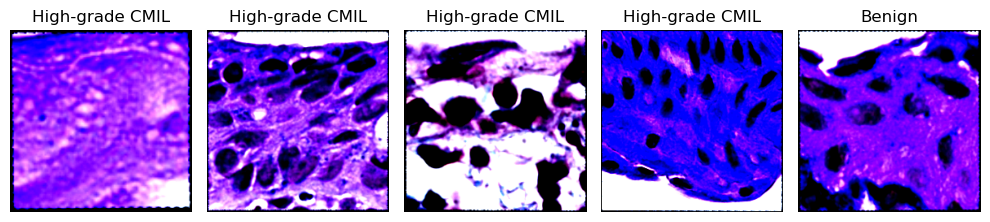


Train Set: Total Patches = 10847
  Benign (0):      3657
  High-grade (1):  7190

Validation Set: Total Patches = 4000
  Benign (0):      1176
  High-grade (1):  2824

Test Set: Total Patches = 3891
  Benign (0):      1134
  High-grade (1):  2757


In [28]:
from collections import defaultdict
from random import seed, shuffle
import numpy as np

seed(42)

# Build case-to-patch count lookup by class
case_classes = labels.drop_duplicates('Case').set_index('Case')['BinaryClass'].to_dict()

# Group cases by class
benign_cases = [(case, patch_counts[case]) for case, label in case_classes.items() if label == 0 and case in patch_counts]
high_grade_cases = [(case, patch_counts[case]) for case, label in case_classes.items() if label == 1 and case in patch_counts]

# Shuffle cases
shuffle(benign_cases)
shuffle(high_grade_cases)

# Helper to assign cases while balancing patch counts across splits
def split_cases_by_patch_count(cases):
    total_patches = sum(p for _, p in cases)
    target = {
        'train': int(0.6 * total_patches),
        'val': int(0.2 * total_patches),
        'test': total_patches - int(0.6 * total_patches) - int(0.2 * total_patches),
    }
    splits = {'train': [], 'val': [], 'test': []}
    counts = {'train': 0, 'val': 0, 'test': 0}

    for case, count in cases:
        # Choose the split with the most room left
        space_left = {k: target[k] - counts[k] for k in ['train', 'val', 'test']}
        split = max(space_left.items(), key=lambda x: x[1])[0]
        splits[split].append(case)
        counts[split] += count

    return splits['train'], splits['val'], splits['test']

# Split cases by patch count balance
train_benign, val_benign, test_benign = split_cases_by_patch_count(benign_cases)
train_high, val_high, test_high = split_cases_by_patch_count(high_grade_cases)

# Final case assignments
train_cases = train_benign + train_high
val_cases = val_benign + val_high
test_cases = test_benign + test_high

# Match patches
train_patches = {c: patches[c] for c in train_cases}
val_patches = {c: patches[c] for c in val_cases}
test_patches = {c: patches[c] for c in test_cases}

# Create datasets
train_dataset = PNGDataset(train_patches, labels, transform=train_transform)
val_dataset = PNGDataset(val_patches, labels, transform=eval_transform)
test_dataset = PNGDataset(test_patches, labels, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualize samples
images, labels_batch = next(iter(train_loader))
fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
for i in range(5):
    axes[i].imshow(images[i].permute(1, 2, 0))
    axes[i].set_title('Benign' if labels_batch[i] == 0 else 'High-grade CMIL')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Print patch distribution per set
def print_loader_stats(name, dataset):
    counts = Counter(dataset.labels)
    print(f"\n{name} Set: Total Patches = {len(dataset)}")
    print(f"  Benign (0):      {counts.get(0, 0)}")
    print(f"  High-grade (1):  {counts.get(1, 0)}")

print_loader_stats("Train", train_dataset)
print_loader_stats("Validation", val_dataset)
print_loader_stats("Test", test_dataset)


In [30]:
# Define validation loss and accuracy

def validation(model, criterion, val_loader):
    val_loss = 0
    accuracy = 0

    for images, labels in iter(val_loader):
        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)

        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, accuracy

In [31]:
import os
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=3,
                scheduler=None, resume_from=None, device='cuda' if torch.cuda.is_available() else 'cpu'):

    train_losses = []
    val_losses = []
    val_accuracies = []

    model_dir = "./models_5_21"
    os.makedirs(model_dir, exist_ok=True)

    model.to(device)
    best_acc = 0
    start_epoch = 0

    # Resume from checkpoint if specified
    if resume_from is not None and os.path.exists(resume_from):
        checkpoint = torch.load(resume_from, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint.get('val_accuracy', 0)
        print(f"🔁 Resumed from checkpoint at epoch {start_epoch} with accuracy {best_acc:.4f}")

    for e in range(start_epoch, epochs):
        model.train()
        running_loss = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {e+1}/{epochs}", leave=True)
        for images, labels in train_bar:
            images = [img.to(device) for img in images]
            labels = labels.to(device)
            images = torch.stack(images)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss / (train_bar.n + 1))

        epoch_train_loss = running_loss / len(train_loader)

        # Step the learning rate scheduler if present
        if scheduler:
            scheduler.step()

        # Validation
        model.eval()
        with torch.no_grad():
            validation_loss = 0
            correct = 0
            total = 0

            for images, labels in val_loader:
                images = [img.to(device) for img in images]
                labels = labels.to(device)
                images = torch.stack(images)

                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            avg_val_loss = validation_loss / len(val_loader)
            val_accuracy = correct / total

        print(
            f"Epoch: {e+1}/{epochs}.. "
            f"Train Loss: {epoch_train_loss:.3f}.. "
            f"Val Loss: {avg_val_loss:.3f}.. "
            f"Val Accuracy: {val_accuracy:.3f}"
        )

        # Save checkpoint
        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        }, os.path.join(model_dir, f"model_epoch_{e+1}.pth"))

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), os.path.join(model_dir, "best_model.pth"))
            print(f"✅ New best model saved at epoch {e+1} with accuracy {val_accuracy:.4f}")

        train_losses.append(epoch_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

    # Plotting
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy During Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [32]:
def save_checkpoint(model, class_mapping, arch):
    """
    Save trained model weights.

    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    timestamp = datetime.now().date().strftime("%Y%m%d")
    torch.save(checkpoint, f"../checkpoint/{timestamp}_{arch}.pth")
     

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# === Step 1: Define KimiaNet model based on DenseNet ===
class KimiaNetClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(KimiaNetClassifier, self).__init__()
        base = models.densenet121(pretrained=False)  # Don't use ImageNet weights
        
        # Replace the classifier head to match your task
        self.features = base.features
        self.classifier = nn.Linear(1024, num_classes)  # DenseNet121 output is 1024-d

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.relu(x, inplace=True)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.classifier(x)

# === Step 2: Instantiate model ===
model = KimiaNetClassifier(num_classes=2)

# === Step 3: Load KimiaNet weights ===
kimianet_path = '/Users/harveywang/Downloads/KimiaNetPyTorchWeights.pth'
state_dict = torch.load(kimianet_path, map_location='cpu')

# Remove the original classifier weights if class count differs
filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('classifier')}
model.load_state_dict(filtered_state_dict, strict=False)

# === Step 4: Optimizer and Loss ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/Users/harveywang/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/harveywang/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [34]:
# Train model
kimianet_model = train_model(model, optimizer, criterion, train_loader, val_loader)

Epoch 1/3: 100%|██████████| 339/339 [1:16:00<00:00, 13.45s/it, loss=0.287]  


Epoch: 1/3.. Train Loss: 0.287.. Val Loss: 1.277.. Val Accuracy: 0.540
✅ New best model saved at epoch 1 with accuracy 0.5400


Epoch 2/3: 100%|██████████| 339/339 [1:14:47<00:00, 13.24s/it, loss=0.176] 


Epoch: 2/3.. Train Loss: 0.176.. Val Loss: 1.535.. Val Accuracy: 0.554
✅ New best model saved at epoch 2 with accuracy 0.5545


Epoch 3/3:   4%|▍         | 14/339 [02:01<46:49,  8.64s/it, loss=0.185]


KeyboardInterrupt: 

In [35]:
import torch

# === Instantiate KimiaNet model based on DenseNet ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KimiaNetClassifier(num_classes=2).to(device)

# === Load trained KimiaNet weights ===
model.load_state_dict(torch.load('/Users/harveywang/models_5_21/best_model.pth', map_location=device))

# === Set model to evaluation mode ===
model.eval()


KimiaNetClassifier(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [36]:
def get_predictions(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [37]:
# Get true and predicted labels
true_labels, pred_labels = get_predictions(model, test_loader) 

In [38]:
# If binary classification, use average='binary'; for multiclass use 'macro' or 'weighted'
precision = precision_score(true_labels, pred_labels, average='binary')
recall = recall_score(true_labels, pred_labels, average='binary')
f1 = f1_score(true_labels, pred_labels, average='binary')
accuracy = accuracy_score(true_labels, pred_labels)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.6101
Precision: 0.7388
Recall:    0.6957
F1 Score:  0.7166


In [39]:
print(set(pred_labels))  # Should be {0, 1} ideally


{0, 1}


In [40]:
from collections import Counter
print(Counter(train_dataset.labels))

Counter({1: 7190, 0: 3657})


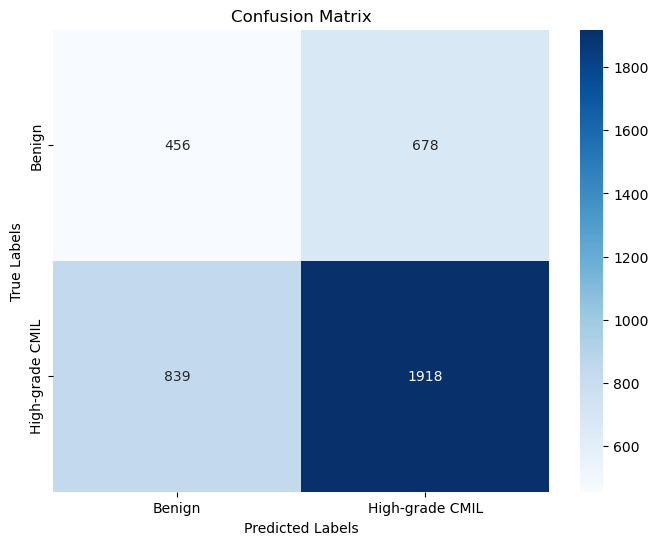

In [41]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Benign', 'High-grade CMIL'],
            yticklabels=['Benign', 'High-grade CMIL'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [42]:
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['Benign', 'Malignant']))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.35      0.40      0.38      1134
   Malignant       0.74      0.70      0.72      2757

    accuracy                           0.61      3891
   macro avg       0.55      0.55      0.55      3891
weighted avg       0.63      0.61      0.62      3891



In [ ]:
import cv2
from torchvision import transforms
from torch.nn import functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        loss = output[:, class_idx].sum()
        self.model.zero_grad()
        loss.backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        grad_cam_map = (weights * self.activations).sum(dim=1, keepdim=True)
        grad_cam_map = F.relu(grad_cam_map)
        grad_cam_map = F.interpolate(grad_cam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        grad_cam_map = grad_cam_map.squeeze().cpu().numpy()
        grad_cam_map -= grad_cam_map.min()
        grad_cam_map /= grad_cam_map.max()
        return grad_cam_map

# Instantiate Grad-CAM using final bottleneck block
target_layer = model.features[10][-1]
cam = GradCAM(model, target_layer)

# Process first 5 patches in test loader
num_images = 5
image_batch, label_batch = next(iter(test_loader))

plt.figure(figsize=(15, 3 * num_images))
for i in range(num_images):
    input_tensor = image_batch[i].unsqueeze(0)
    label = label_batch[i].item()
    pred_class = model(input_tensor).argmax().item()
    
    heatmap = cam.generate(input_tensor)
    
    img = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    heatmap_img = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.uint8(255 * img), 0.6, heatmap_img, 0.4, 0)

    # Extract case number if filename or metadata available
    try:
        filename = test_loader.dataset.image_paths[i]
        case_match = re.search(r"case_(\d+)", filename)
        case_str = f"Case {case_match.group(1)}" if case_match else "Unknown Case"
    except:
        case_str = "Unknown Case"

    # Plot original and overlay
    plt.subplot(num_images, 2, 2*i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{case_str} - Original")

    plt.subplot(num_images, 2, 2*i + 2)
    plt.imshow(overlay[..., ::-1])
    plt.axis('off')
    plt.title(f"{case_str} - Grad-CAM (True: {label}, Pred: {pred_class})")

plt.tight_layout()
plt.show()

In [ ]:
#Using GradCam just before CBAM layers to cisualize pre-attention learning:

In [ ]:

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.eval()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        loss = output[:, class_idx].sum()
        self.model.zero_grad()
        loss.backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        grad_cam_map = (weights * self.activations).sum(dim=1, keepdim=True)
        grad_cam_map = F.relu(grad_cam_map)
        grad_cam_map = F.interpolate(grad_cam_map, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        grad_cam_map = grad_cam_map.squeeze().cpu().numpy()
        grad_cam_map -= grad_cam_map.min()
        grad_cam_map /= grad_cam_map.max()
        return grad_cam_map

# === 🔧 Identify the layer before CBAM ===
# Example: if CBAM is inserted after the last Bottleneck in layer4,
# hook the output before CBAM (usually conv3 or bottleneck forward)

# If your model uses this pattern:
# model.features = Sequential(
#     ...
#     (10): Sequential(  # layer4
#         (2): Bottleneck(...)  # last block
#     )
# )
# Then:
target_layer = model.features[10][2].conv3  # or .bn3 if conv3 is followed by BN
cam = GradCAM(model, target_layer)

# === Grad-CAM visualization ===
num_images = 5
image_batch, label_batch = next(iter(test_loader))

plt.figure(figsize=(15, 3 * num_images))
for i in range(num_images):
    input_tensor = image_batch[i].unsqueeze(0)
    label = label_batch[i].item()
    pred_class = model(input_tensor).argmax().item()

    heatmap = cam.generate(input_tensor)

    img = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    heatmap_img = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.uint8(255 * img), 0.6, heatmap_img, 0.4, 0)

    try:
        filename = test_loader.dataset.image_paths[i]
        case_match = re.search(r"case_(\d+)", filename)
        case_str = f"Case {case_match.group(1)}" if case_match else "Unknown Case"
    except:
        case_str = "Unknown Case"

    plt.subplot(num_images, 2, 2*i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{case_str} - Original")

    plt.subplot(num_images, 2, 2*i + 2)
    plt.imshow(overlay[..., ::-1])
    plt.axis('off')
    plt.title(f"{case_str} - Grad-CAM (True: {label}, Pred: {pred_class})")

plt.tight_layout()
plt.show()